In [86]:
import pandas as pd

# Load the sample energy data
file_path = './Sample_Energy_Data.csv'
energy_data = pd.read_csv(file_path)

# Display the first few rows and summary of the data to understand its structure
energy_data.info(), energy_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346 entries, 0 to 345
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Site Code                   346 non-null    object 
 1   Site Name                   346 non-null    object 
 2   CA Number                   346 non-null    object 
 3   Board Name                  346 non-null    object 
 4   Closing Meter Reading       335 non-null    float64
 5   Opening Meter Reading       342 non-null    float64
 6   Unit Consumption            345 non-null    float64
 7   Bill Month                  346 non-null    object 
 8   Bill Date                   346 non-null    object 
 9   Due Date                    346 non-null    object 
 10  Amount Before Due Date      346 non-null    float64
 11  Amount After Due Date       345 non-null    float64
 12  Sanctioned Load             310 non-null    float64
 13  Connected Load              270 non

(None,
      Site Code         Site Name      CA Number  \
 0  1247_BRANCH  Vashi-Palm Beach  74182524_CODE   
 1  1247_BRANCH  Vashi-Palm Beach  74182524_CODE   
 2  1247_BRANCH  Vashi-Palm Beach  74182524_CODE   
 3  1247_BRANCH  Vashi-Palm Beach  74182524_CODE   
 4  1247_BRANCH  Vashi-Palm Beach  74182524_CODE   
 
                                           Board Name  Closing Meter Reading  \
 0  MAHARASHTRA STATE ELECTRICITY DISTRIBUTION COM...              512477.36   
 1  MAHARASHTRA STATE ELECTRICITY DISTRIBUTION COM...              520875.50   
 2  MAHARASHTRA STATE ELECTRICITY DISTRIBUTION COM...              503845.52   
 3  MAHARASHTRA STATE ELECTRICITY DISTRIBUTION COM...              473400.67   
 4  MAHARASHTRA STATE ELECTRICITY DISTRIBUTION COM...              494273.76   
 
    Opening Meter Reading  Unit Consumption Bill Month    Bill Date  \
 0              503845.52            8632.0   Aug 2024  Aug 4, 2024   
 1              512477.36            8398.0   Sep 2024 

### Data Analysis Summary
The dataset contains 30 columns with a mix of numerical and categorical data. Key observations:

Columns:

1. Identification: Site Code, Site Name, CA Number, Board Name.
2. Energy Data: Closing Meter Reading, Opening Meter Reading, Unit Consumption.
3. Billing Information: Amount Before Due Date, Amount After Due Date, Bill Month, Bill Date, Due Date.
4. Other Metrics: Power Factor, Excess Demand Charges, Green Tariff (kWh), etc.

Null Values:
- Several columns have missing data, e.g., Connected Load, Power Factor Penalty.

Data Types:
- Dates are in object format and need conversion.
- Most numeric fields are in float64.


## The workflow

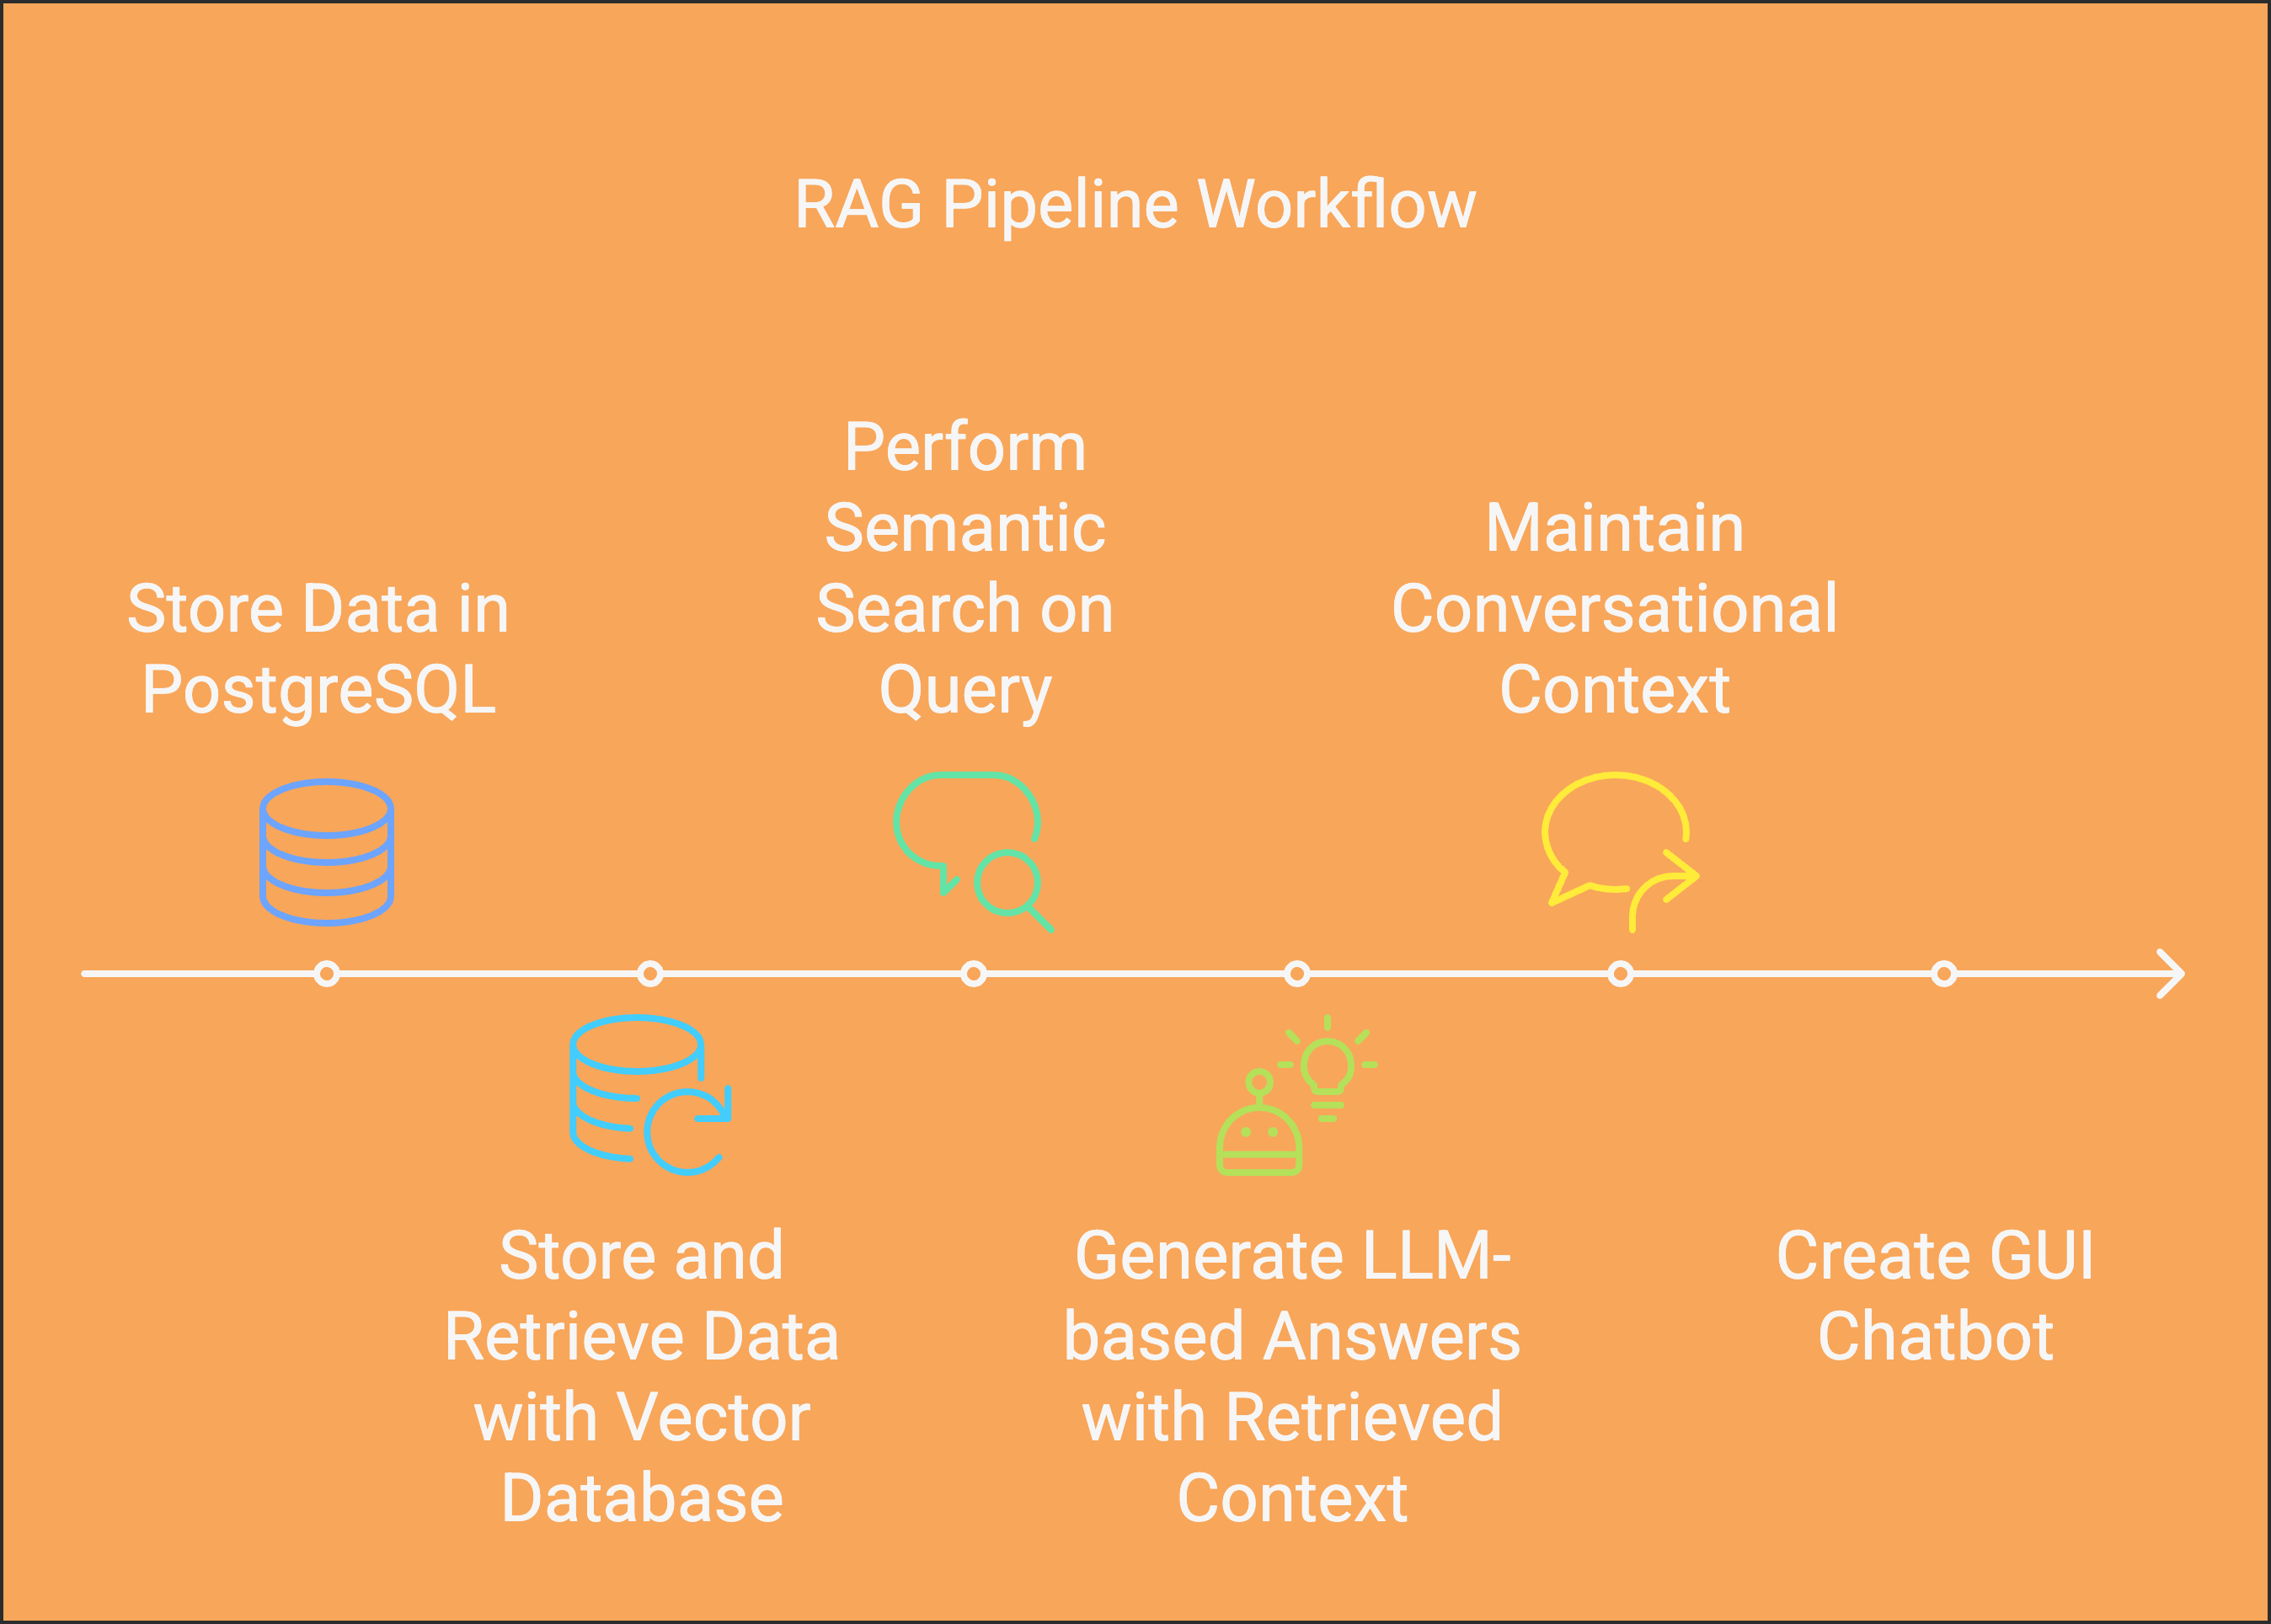

In [5]:
import pandas as pd
import psycopg2
from psycopg2 import sql
from sentence_transformers import SentenceTransformer
# from transformers import AutoTokenizer, AutoModelForCausalLM
import faiss
import numpy as np
import json
import datetime
import openai

/Users/mdwivedi/anaconda3/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [6]:
open_ai_api = 'replace with your key'

### Setup PostgreSQL and Insert the Data

In [7]:
# Load the dataset
file_path = './Sample_Energy_Data.csv'
data = pd.read_csv(file_path)

# Lets Define PostgreSQL connection parameters
db_config = {
    'dbname': 'energy_data',  
    'user': 'myuser',       
    'password': 'mypassword',
    'host': 'localhost',
    'port': 5432
}

In [8]:
# Define the table creation query
def create_table():
    query = """
    CREATE TABLE IF NOT EXISTS energy_data (
        site_code VARCHAR(50),
        site_name VARCHAR(255),
        ca_number VARCHAR(50),
        board_name VARCHAR(255),
        closing_meter_reading FLOAT,
        opening_meter_reading FLOAT,
        unit_consumption FLOAT,
        bill_month VARCHAR(20),
        bill_date DATE,
        due_date DATE,
        amount_before_due_date FLOAT,
        amount_after_due_date FLOAT,
        sanctioned_load FLOAT,
        connected_load FLOAT,
        contract_demand FLOAT,
        kva_40_percent_demand FLOAT,
        tariff VARCHAR(50),
        category VARCHAR(50),
        early_payment_amount FLOAT,
        early_payment_date DATE,
        opening_meter_reading_date DATE,
        closing_meter_reading_date DATE,
        maximum_demand FLOAT,
        maximum_demand_kva FLOAT,
        excess_demand_charges FLOAT,
        power_factor FLOAT,
        power_factor_penalty FLOAT,
        green_tariff_kwh FLOAT,
        digital_payment_benefit FLOAT,
        late_payment_penalty FLOAT,
        PRIMARY KEY (site_code, bill_month)
    );
    """
    return query

# Function to insert data into the table
def insert_data(cursor, data):
    for _, row in data.iterrows():
        # Replace pandas NaT and NaN with None
        row = row.where(pd.notnull(row), None)
        
        insert_query = sql.SQL(
            """
            INSERT INTO energy_data (
                site_code, site_name, ca_number, board_name, closing_meter_reading,
                opening_meter_reading, unit_consumption, bill_month, bill_date, due_date,
                amount_before_due_date, amount_after_due_date, sanctioned_load, connected_load,
                contract_demand, kva_40_percent_demand, tariff, category, early_payment_amount,
                early_payment_date, opening_meter_reading_date, closing_meter_reading_date,
                maximum_demand, maximum_demand_kva, excess_demand_charges, power_factor,
                power_factor_penalty, green_tariff_kwh, digital_payment_benefit, late_payment_penalty
            ) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
            ON CONFLICT (site_code, bill_month) DO NOTHING;
            """
        )
        cursor.execute(insert_query, tuple(row))
        

## Vectorize data, save locally and load it

In [9]:
# Function to retrieve and vectorize data
def vectorize_data():
    try:
        # Connect to PostgreSQL
        conn = psycopg2.connect(**db_config)
        cursor = conn.cursor()

        # Retrieve all columns from PostgreSQL
        cursor.execute("SELECT * FROM energy_data;")
        rows = cursor.fetchall()
        column_names = [desc[0] for desc in cursor.description]

        # Prepare data for vectorization
        text_data = []
        serializable_rows = []
        for row in rows:
            row_text = " ".join([f"{column_names[i]}: {str(value)}" for i, value in enumerate(row) if value is not None])
            text_data.append(row_text)

            # Convert date objects to strings for JSON serialization
            serializable_row = [value.isoformat() if isinstance(value, (datetime.date, datetime.datetime)) else value for value in row]
            serializable_rows.append(serializable_row)

        # Load sentence transformer model
        model = SentenceTransformer('all-MiniLM-L6-v2')

        # Generate embeddings
        embeddings = model.encode(text_data)

        # Initialize FAISS index
        dimension = embeddings.shape[1]
        index = faiss.IndexFlatL2(dimension)

        # Add embeddings to the index
        index.add(np.array(embeddings))

        # Save the index to a file
        faiss.write_index(index, 'faiss_index.bin')

        # Save the raw data to a JSON file
        with open('raw_data.json', 'w') as f:
            json.dump(serializable_rows, f)

        print("Data vectorized and stored in FAISS index.")
        return index, serializable_rows, column_names

    except Exception as e:
        print("Error:", e)
    finally:
        if conn:
            cursor.close()
            conn.close()

# Function to load the FAISS index and raw data
def load_index_and_data():
    try:
        # Load the FAISS index
        index = faiss.read_index('faiss_index.bin')

        # Load the raw data
        with open('raw_data.json', 'r') as f:
            raw_data = json.load(f)

        print("Index and raw data loaded successfully.")
        return index, raw_data

    except Exception as e:
        print("Error loading index and data:", e)
        return None, None

## RAG pipeline

Below is the workflow which is to extract the rsults

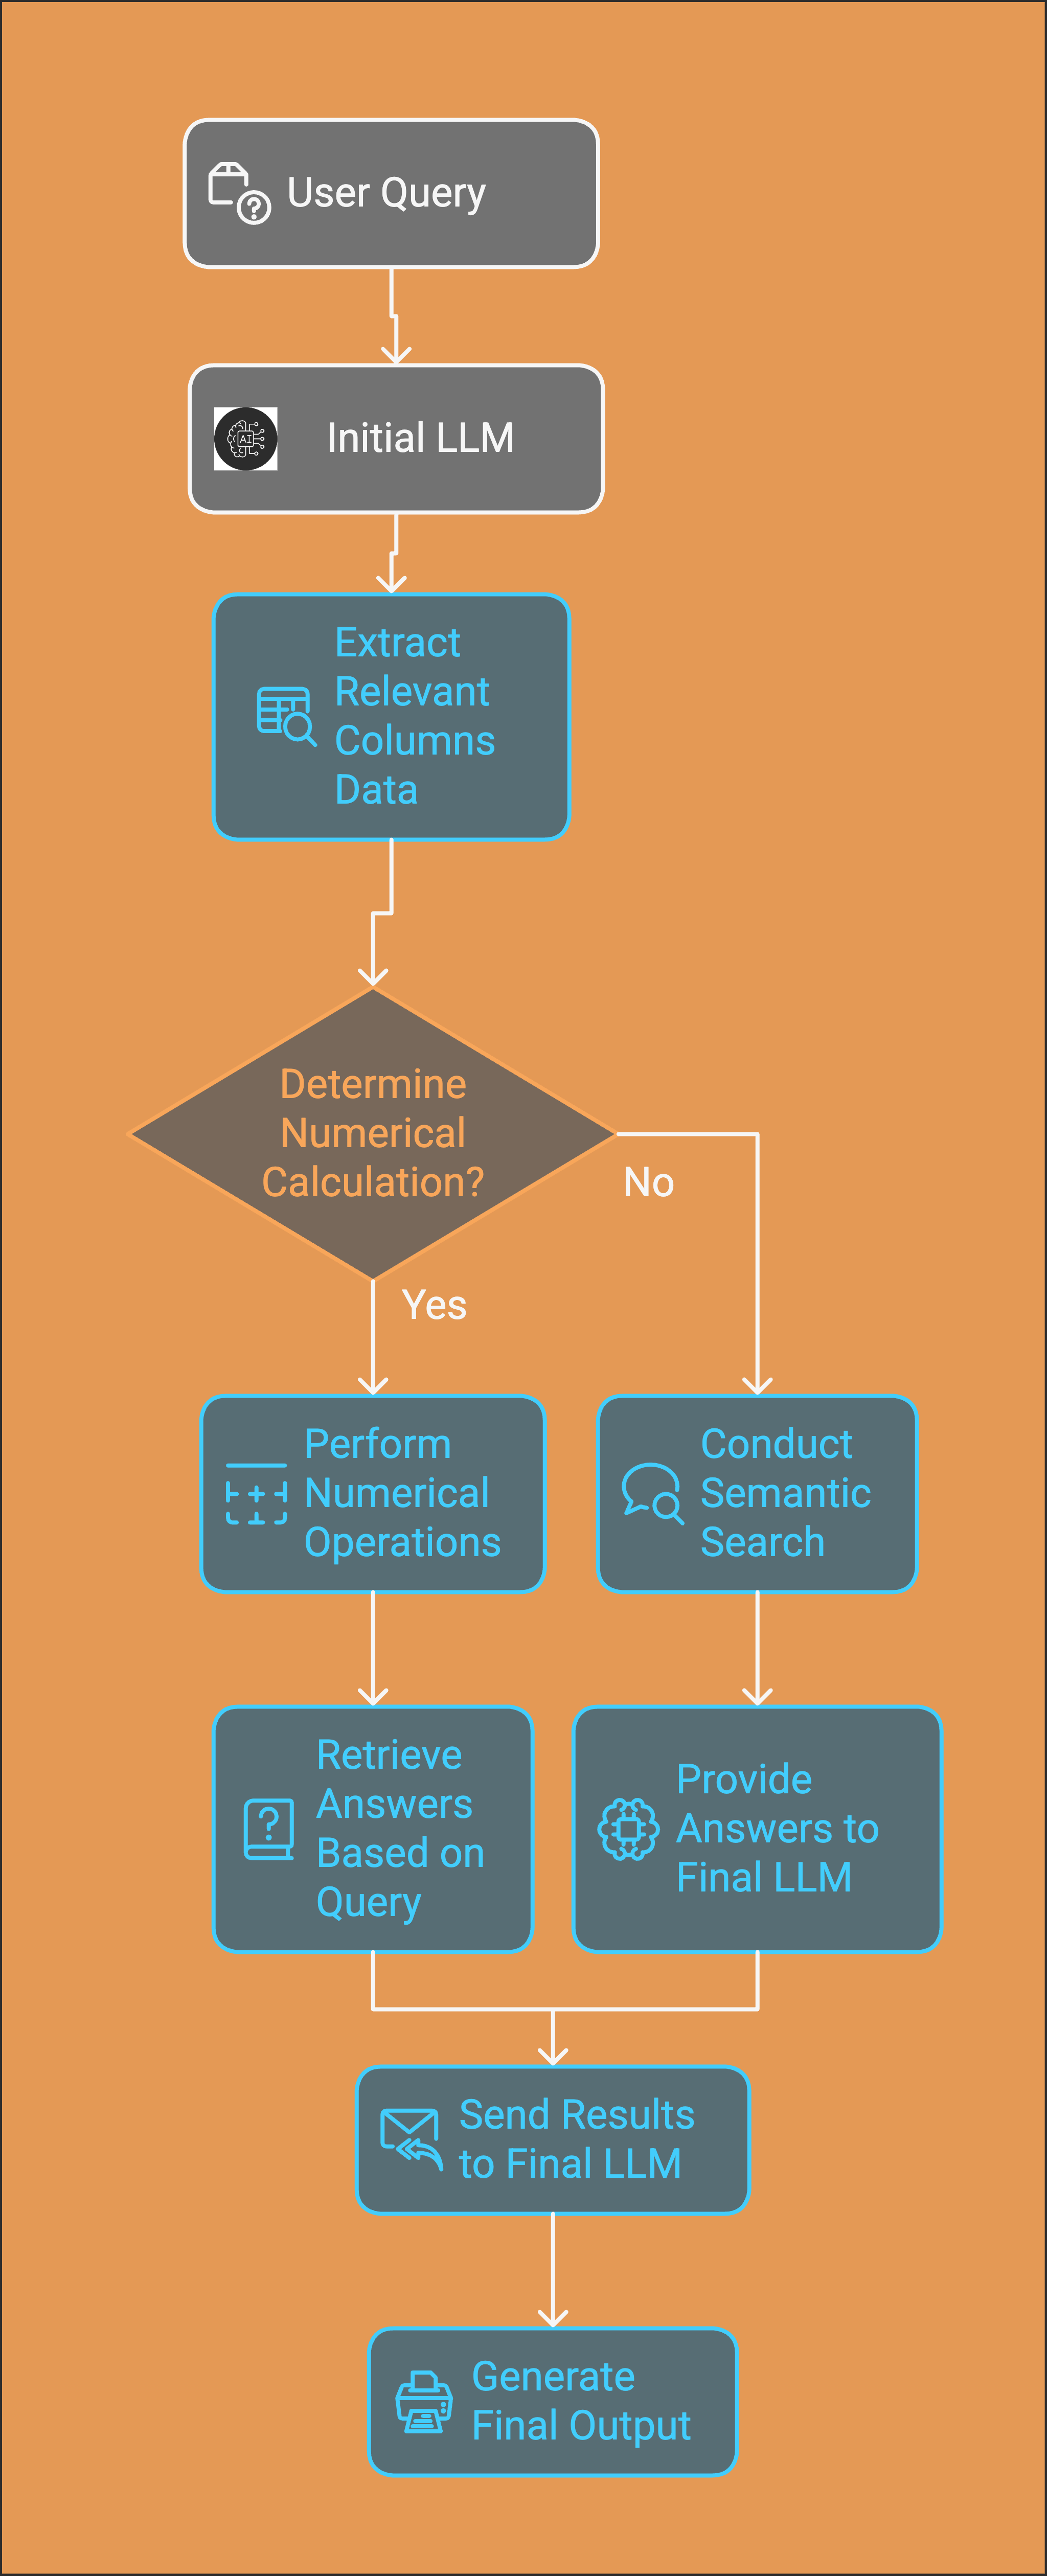

In [10]:
def identify_columns_with_llm(query, column_names):
    """
    Identifies relevant columns and operations using LLM, with support for conversation history.

    Args:
        query (str): Current user query.
        column_names (list): List of column names in the schema.

    Returns:
        str: Instructions generated by the LLM.
    """
    try:
        openai.api_key = open_ai_api
        
        # Retrieve the latest context from conversation history
        context = conversation_history[-1] if conversation_history else None
        
        # Format schema for LLM
        schema_description = "\n".join([f"- {col}" for col in column_names])
        
        # Add context to the prompt if available
        context_description = ""
        if context:
            context_description = (
                f"Previous Query: {context['query']}\n"
                f"Previous Instructions: {context.get('instructions', 'None')}\n"
                f"Previous Results: {context.get('retrieved_results', 'None')}\n\n"
            )
        
        # Prepare the LLM prompt
        prompt = (
        "You are a highly intelligent and helpful assistant. Your task is to analyze a given database schema, "
        "consider the user's query, and determine the appropriate numeric operation to perform. You must also consider "
        "conversation history to provide contextually relevant responses.\n\n"
        "The operation should involve numeric calculations (e.g., sorting, averaging, summing).\n\n"
        "Schema:\n"
        f"{schema_description}\n\n"
        "Conversation History:\n"
        f"{context_description}\n"
        "Current Query:\n"
        f"{query}\n\n"
        "### Instructions ###\n"
        "1. If the query involves a numeric operation (e.g., sorting, averaging, summing), provide:\n"
        "   - Target column: The numeric column where the operation should be performed.\n"
        "   - Operation: The type of operation (e.g., sort descending, average).\n"
        "   - Related columns: Additional columns required to provide context or detailed output.\n\n"
        "2. If no numeric operation is required, return 'Target column: None'.\n\n"
        "### Few-Shot Examples ###\n\n"
        "#### Example 1 ####\n"
        "Query: What is the average power factor across all sites?\n"
        "Response:\n"
        "Target column: power_factor\n"
        "Operation: average\n"
        "Related columns: site_name\n\n"
        "#### Example 2 ####\n"
        "Query: Find the maximum unit consumption and the corresponding site.\n"
        "Response:\n"
        "Target column: unit_consumption\n"
        "Operation: max\n"
        "Related columns: site_name, site_code\n\n"
        "#### Example 3 ####\n"
        "Query: Show me the top 5 sites with the highest unit consumption.\n"
        "Response:\n"
        "Target column: unit_consumption\n"
        "Operation: sort descending\n"
        "Related columns: site_name, site_code\n\n"
        "#### Example 4 ####\n"
        "Query: What is the total sanctioned load across all sites?\n"
        "Response:\n"
        "Target column: sanctioned_load\n"
        "Operation: sum\n"
        "Related columns: None\n\n"
        "#### Example 5 ####\n"
        "Query: Find the minimum connected load among all sites.\n"
        "Response:\n"
        "Target column: connected_load\n"
        "Operation: min\n"
        "Related columns: None\n\n"
        "### Response Format ###\n"
        "Provide your response in this exact format:\n"
        "Target column: <target_column>\n"
        "Operation: <operation>\n"
        "Related columns: <related_column1>, <related_column2>, ..."
    )

        # Call the LLM API
        response = openai.ChatCompletion.create(
            model="gpt-4-turbo",
            messages=[
                {"role": "system", "content": "You are a helpful assistant."},
                {"role": "user", "content": prompt}
            ],
            max_tokens=300,
            temperature=0.5
        )
        
        # Extract and log column instructions
        column_instructions = response['choices'][0]['message']['content'].strip()
        print("Column Instructions from LLM:", column_instructions)
        
        # Add the current query and instructions to conversation history
        conversation_history.append({
            "query": query,
            "instructions": column_instructions,
            "retrieved_results": None  # Update this with actual results after retrieval
        })
        
        return column_instructions

    except Exception as e:
        print(f"Error identifying columns with LLM: {e}")
        return ""


In [11]:
def handle_numeric_operations(query, column_instructions, raw_data, column_names):
    """
    Handles numeric operations based on LLM instructions, logs results in conversation history.

    Args:
        column_instructions (str): Instructions from LLM about numeric operations.
        raw_data (list): Raw data rows from the database.
        column_names (list): Column names from the database schema.

    Returns:
        tuple: Processed data (top results or aggregation) and an error message if any.
    """
    try:
        # Extract target column, operation, and related columns
        target_column = None
        operation = None
        related_columns = []

        for line in column_instructions.split("\n"):
            if line.startswith("Target column:"):
                target_column = line.split(":", 1)[1].strip()
            elif line.startswith("Operation:"):
                operation = line.split(":", 1)[1].strip()
            elif line.startswith("Related columns:"):
                related_columns = [col.strip() for col in line.split(":", 1)[1].split(",")]

        if not target_column or target_column == "None":
            return None, "No numeric operation required."

        # Validate and find the index of the target column
        try:
            col_idx = column_names.index(target_column)
        except ValueError:
            raise ValueError(f"Target column '{target_column}' not found in column names.")

        # Filter rows with valid numeric data
        numeric_data = [
            row for row in raw_data if isinstance(row[col_idx], (int, float)) and row[col_idx] is not None
        ]

        if not numeric_data:
            raise ValueError(f"No valid numeric data found in the '{target_column}' column.")

        # Supported operations as of now
        operations = {
        "sort descending": lambda numeric_data: [
            {**{"value": row[col_idx]}, **{col: row[column_names.index(col)] for col in related_columns}}
            for row in sorted(numeric_data, key=lambda x: x[col_idx], reverse=True)[:5]
        ],
        "sort ascending": lambda numeric_data: [
            {**{"value": row[col_idx]}, **{col: row[column_names.index(col)] for col in related_columns}}
            for row in sorted(numeric_data, key=lambda x: x[col_idx])[:5]
        ],
        "average": lambda numeric_data: [
            {"average": sum(row[col_idx] for row in numeric_data) / len(numeric_data), "related_columns": related_columns}
        ],
        "sum": lambda numeric_data: [
            {"sum": sum(row[col_idx] for row in numeric_data), "related_columns": related_columns}
        ],
        "max": lambda numeric_data: [
            {**{"value": max(row[col_idx] for row in numeric_data)},
             **{col: row[column_names.index(col)] for col in related_columns
                for row in numeric_data if row[col_idx] == max(row[col_idx] for row in numeric_data)}}
        ],
        "min": lambda numeric_data: [
            {**{"value": min(row[col_idx] for row in numeric_data)},
             **{col: row[column_names.index(col)] for col in related_columns
                for row in numeric_data if row[col_idx] == min(row[col_idx] for row in numeric_data)}}
        ]
    }

        # Lets match operation and execute
        for op_keyword, operation_func in operations.items():
            if op_keyword in operation.lower():
                result = operation_func(numeric_data)

                # Log results in conversation history
                conversation_history.append({
                    "query": f"Operation: {operation} on {target_column}",
                    "instructions": column_instructions,
                    "results": result
                })

                return result

#         return None, f"Numeric operation '{operation}' not implemented."

    except Exception as e:
        print(f"Error in handle_numeric_operations: {e}")
        return None, f"Error in numeric operation: {e}"

In [12]:
# Function to perform semantic search and log results in history
def semantic_search(query, index, raw_data, column_names, model, top_k=10):
    try:
        # Generate query embedding
        query_embedding = model.encode([query])

        # Perform FAISS search
        distances, indices = index.search(np.array(query_embedding), top_k)

        # Retrieve top results
        results = [raw_data[idx] for idx in indices[0]]

        # Add query and results to conversation history
        conversation_history.append({"query": query, "retrieved_results": results})

#         print("\nRetrieved rows:")
#         for row in results:
#             formatted_row = " | ".join([f"{col}: {val}" for col, val in zip(column_names, row)])
#             print(formatted_row)

        return results

    except Exception as e:
        print("Error during semantic search:", e)
        return []

In [13]:
def detect_follow_up(query):
    """
    Detects if the query is a follow-up and retrieves relevant context from conversation history.

    Args:
        query (str): The current user query.

    Returns:
        dict: Relevant context from conversation history or None.
    """
    follow_up_keywords = ["it", "that", "those", "previous", "last", "sum"]
    if any(keyword in query.lower() for keyword in follow_up_keywords):
        return conversation_history[-1] if conversation_history else None
    return None

In [14]:
# # Global variable to store conversation history
conversation_history = []

In [15]:
# Function to format results into a prompt
def create_general_prompt(query, results):
    prompt = "You are a helpful assistant. Use the following data to answer the query.\n\n"
    prompt += f"Query: {query}\n\nData:\n"
    for result in results:
        prompt += f"- Data Row: {result}\n"
    prompt += "\nAnswer:"
    return prompt

In [16]:
# Function to generate LLM response using GPT-4o-mini

def generate_llm_response_from_results(query, sorted_data, column_names):
    """
    Generates an LLM response based on sorted results.

    Args:
        query (str): The original user query.
        sorted_data (list): The sorted data (top results).
        column_names (list): List of column names in the database.

    Returns:
        str: A human-readable response generated by LLM.
    """
    try:
        openai.api_key = open_ai_api

        # Validate sorted_data
        if not sorted_data or len(sorted_data) == 0:
            return "No data available to generate a response."

        # Format the results into a readable string
        results_str = "\n".join(
            [
                f"{i + 1}. " + ", ".join([f"{col}: {row[idx]}" for idx, col in enumerate(column_names) if idx < len(row)])
                for i, row in enumerate(sorted_data)
            ]
        )

        # Prepare the prompt
        prompt = (
            "You are a helpful assistant. Based on the following query and the sorted results, provide a concise summary.\n\n"
            f"Query: {query}\n\n"
            f"Results:\n{results_str}\n\n"
            "Provide a response to answer the query based on the results."
        )

        # Call the LLM to generate a response
        response = openai.ChatCompletion.create(
            model="gpt-4o-mini",
            messages=[
                {"role": "system", "content": "You are a helpful assistant."},
                {"role": "user", "content": prompt}
            ],
            max_tokens=200,
            temperature=0.7
        )

        return response['choices'][0]['message']['content'].strip()

    except Exception as e:
        print(f"Error generating LLM response: {e}")
        return "Unable to generate a response."


In [18]:
def process_numeric_result(query, result):
    """
    Formats the result of a numeric operation for response generation.

    Args:
        result: The result of the numeric operation (list, dict, or other formats).

    Returns:
        str: A formatted string for the result.
    """
    if isinstance(result, list):
        # Handle list results (e.g., top 5 rows)
        return "\n".join([str(row) for row in result])
    elif isinstance(result, dict):
        # Handle dictionary results (e.g., averages, sums)
        return ", ".join([f"{key}: {value}" for key, value in result.items()])
    else:
        # Handle unexpected result formats
        return str(result)
    
    prompt = (
    "You are a helpful assistant. Based on the given query and results, extract and format the answer in a clear and concise manner.\n\n"
    "Query:\n"
    f"{query}\n\n"
    "Results (only relevant fields):\n"
    f"{results}\n\n"
    "### Instructions ###\n"
    "1. Always start with a single sentence summarizing the result and its relevance to the query.\n"
    "2. For queries asking for a single result (e.g., the highest value), provide the answer in one line:\n"
    "   - Example: 'The site with the highest unit consumption is Pune-Pride Parmar with 161,252 units.'\n"
    "3. Avoid returning raw data. Ensure the response is formatted and easy to understand."
)

    # Main handling
    if result:
        formatted_result = process_numeric_result(result)
        print("Formatted Result:", formatted_result)  # Debugging log

        # Pass formatted result to LLM
        llm_input = f"The result of your query is:\n{formatted_result}"
        try:
            response = openai.ChatCompletion.create(
                model="gpt-4o-mini",
                messages=[
                    {"role": "system", "content": prompt},
                    {"role": "user", "content": llm_input}
                ],
                max_tokens=150,
                temperature=0.5
            )
            print("LLM Response:", response['choices'][0]['message']['content'])
        except Exception as e:
            print("Error generating LLM response:", e)
    else:
        print("No valid result to process.")


In [25]:
def db_creation_vectorizing():
    # Convert date columns to datetime
    try:
        date_columns = ['Bill Date', 'Due Date', 'Early Payment Date', 'Opening Meter Reading Date', 'Closing Meter Reading Date']
        for col in date_columns:
            data[col] = pd.to_datetime(data[col], errors='coerce')

        conn = psycopg2.connect(**db_config)
        conn.autocommit = True
        cursor = conn.cursor()

        # Create the table
        cursor.execute(create_table())
        print("Table created successfully.")

        # Insert the data
        insert_data(cursor, data)
        print("Data inserted successfully.")

        # Vectorize and store data
        vector_index, raw_data, column_names = vectorize_data()

        # Load index and raw data
        index, raw_data = load_index_and_data()

        # Load the sentence transformer model
        model = SentenceTransformer('all-MiniLM-L6-v2')
        
        return vector_index, raw_data, column_names, index, raw_data, model 

    except Exception as e:
        print("Error:", e)
    finally:
        if conn:
            cursor.close()
            conn.close()

In [26]:
# Main function to execute the Whole workflow

def main():
    try:
        ## Creating table, inserting data and vectorizing it 
        vector_index, raw_data, column_names, index, raw_data, model =  db_creation_vectorizing()
        
        # Example queries:
        
#         query = "Show me the site with the highest unit consumption."
        
#         query = "Which sites are managed by the MAHARASHTRA STATE ELECTRICITY DISTRIBUTION COMPANY LIMITED?"

#         query = "What is the total unit consumption for those sites?"

        query = "Show the site with the lowest connected load."
        
        # Use LLM to identify relevant columns to extract the data
        column_instructions = identify_columns_with_llm(query, column_names)
        print("Column Instructions:", column_instructions)

        # Check if numeric operations are required based on LLM response
        if "Target column" in column_instructions and "Target column: None" not in column_instructions:
            print("Numeric Operation required")
            sorted_data = handle_numeric_operations(query, column_instructions, raw_data, column_names)
            print("Top 5 Results After Numeric Operation:")
            for row in sorted_data:
                print(row)
            
            if sorted_data is None or len(sorted_data) == 0:
                print("No valid results to generate LLM response.")
            else:
                llm_response = process_numeric_result(query, sorted_data)
                print("LLM Response:", llm_response)
            
        else:
            # Perform semantic search
            results = semantic_search(query, index, raw_data, column_names, model)
            print("Semantic Search Results:", results)
            
            llm_response = generate_llm_response_from_results(query, results, column_names)
            print("\nLLM Response:")
            print(llm_response)


    except Exception as e:
        print("Error:", e)

## Execute the main function

In [27]:
if __name__ == "__main__":
    main()

Table created successfully.
Data inserted successfully.
Data vectorized and stored in FAISS index.
Index and raw data loaded successfully.
Column Instructions from LLM: Target column: connected_load
Operation: min
Related columns: site_name, site_code
Column Instructions: Target column: connected_load
Operation: min
Related columns: site_name, site_code
Numeric Operation required
Top 5 Results After Numeric Operation:
{'value': 4.0, 'site_name': 'Bhosari, Pune - Maharashtra', 'site_code': '2352_BRANCH'}
LLM Response: {'value': 4.0, 'site_name': 'Bhosari, Pune - Maharashtra', 'site_code': '2352_BRANCH'}


In [47]:
conversation_history = []

In [28]:
# conversation history
def view_conversation_history():
    print("\nConversation History:")
    for entry in conversation_history:
        print(json.dumps(entry, indent=2))
        
view_conversation_history()


Conversation History:
{
  "query": "Show the site with the lowest connected load.",
  "instructions": "Target column: connected_load\nOperation: min\nRelated columns: site_name, site_code",
  "retrieved_results": null
}
{
  "query": "Operation: min on connected_load",
  "instructions": "Target column: connected_load\nOperation: min\nRelated columns: site_name, site_code",
  "results": [
    {
      "value": 4.0,
      "site_name": "Bhosari, Pune - Maharashtra",
      "site_code": "2352_BRANCH"
    }
  ]
}
{
  "query": "Show the site with the lowest connected load.",
  "instructions": "Target column: connected_load\nOperation: min\nRelated columns: site_name, site_code",
  "retrieved_results": null
}
{
  "query": "Operation: min on connected_load",
  "instructions": "Target column: connected_load\nOperation: min\nRelated columns: site_name, site_code",
  "results": [
    {
      "value": 4.0,
      "site_name": "Bhosari, Pune - Maharashtra",
      "site_code": "2352_BRANCH"
    }
  ]
}

In [1]:
!streamlit run app1.py --server.port 8501

2025-01-22 16:50:47.823 Port 8501 is already in use


### Tried queries and their responses

### Numeric queries

**1. "Which site has the highest unit consumption?"**

- Target column: unit_consumption
- Operation: Sort descending

**Answer:** 

LLM Response: The site with the highest unit consumption is **Pune-Pride Parmar** (site code: 2323_BRANCH), with a unit consumption of **161,252.0 units** for the bill month of June 2024.

**2. "What is the average power factor across all sites?"**

- Target column: power_factor
- Operation: Average

**LLM Response: {'average': 9.7146095890411, 'related_columns': ['site_name']}**

**3. "List the top 3 sites with the highest closing meter readings."**?

- Target column: closing_meter_reading
- Operation: Sort descending

**LLM Response: 
- {'value': 537717.8, 'site_name': 'Vashi-Palm Beach', 'site_code': '1247_BRANCH'}
- {'value': 528584.18, 'site_name': 'Vashi-Palm Beach', 'site_code': '1247_BRANCH'}
- {'value': 520875.5, 'site_name': 'Vashi-Palm Beach', 'site_code': '1247_BRANCH'}
- {'value': 512477.36, 'site_name': 'Vashi-Palm Beach', 'site_code': '1247_BRANCH'}
- {'value': 503845.52, 'site_name': 'Vashi-Palm Beach', 'site_code': '1247_BRANCH'}**

**4. "Show the site with the lowest connected load."**

- Target column: connected_load
- Operation: Sort ascending

**LLM Response: {'value': 4.0, 'site_name': 'Bhosari, Pune - Maharashtra', 'site_code': '2352_BRANCH'}**

### Non-Numeric Queries:

**1. "Show me the details of all sites located in Pune."**

- Related columns: site_name

**LLM Response:**

Here are the details of all sites located in Pune:

1. **Site Name:** Camp, Pune  
   - **Site Code:** 2295_BRANCH  
   - **CA Number:** 160012439323_CODE  
   - **Board Name:** MAHARASHTRA STATE ELECTRICITY DISTRIBUTION COMPANY LIMITED  
   - **Bill Month:** September 2024  
   - **Bill Date:** 2024-09-05  
   - **Due Date:** 2024-09-25  
   - **Opening Meter Reading:** 27768.4  
   - **Closing Meter Reading:** 29377.8  
   - **Unit Consumption:** 1609.0  
   - **Amount Before Due Date:** ₹40,770.0  
   - **Amount After Due Date:** ₹41,280.0  
   - **Sanctioned Load:** 35.0 kW  
   - **Connected Load:** 35.0 kW

**2. "Which sites are managed by the MAHARASHTRA STATE ELECTRICITY DISTRIBUTION COMPANY LIMITED?"**

- Related columns: board_name

**Answer: LLM Response:**

The sites managed by the Maharashtra State Electricity Distribution Company Limited (MSEDCL) include:

1. **Thane Panchpakhdi**
   - Site Code: 2238_BRANCH
   - Consumer Account Number: 14807997_CODE
   - Bill Details: 
     - October 2024: 0 units consumed, amount due before date: ₹510.0
     - November 2024: 0 units consumed, amount due before date: ₹510.0

2. **Ichalkaranji, Maharashtra**
   - Site Code: 2393_BRANCH
   - Consumer Account Number: 250642364488_CODE
   - Bill Details:
     - September 2024: 1316 units consumed, amount due before date: ₹17,540.0
     - July 2024: 1413 units consumed, amount due before date: ₹18,790.0
     - August 2024: 1284 units consumed

**3. "Retrieve all sites where the category is 'Commercial'."**

- Related columns: category

**LLM Response:**

The query retrieved a total of 10 sites categorized as 'Commercial'. Here’s a concise summary of the results:

1. **Sites**: The sites are primarily located in Mumbai, with one in Pune. The notable locations include Santacruz East and Kalina in Mumbai, which have multiple entries.

2. **Billing Details**: Each site has detailed billing information, including meter readings, unit consumption, bill amounts (both before and after due dates), and due dates, covering various months from June to December 2024.


4. **"Total how many sites are located in Pune."**

**LLM Response:**

There is a total of **one site** located in Pune, specifically named "Camp, Pune".